# Supervised Learning with Decision Trees

In [33]:
import os
from PIL import Image, ImageFilter
import numpy as np 
import logging

alphabet_dir = "ASL_Dataset/Train"

images = []
labels = []


In [14]:
max_images_per_folder = 500
size = (256, 256)
def horizontal_flip(image):
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return flipped_image

def remove_noise(image):
    pil_image = Image.fromarray(np.uint8(image*255))  
    denoised_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))
    denoised_array = np.array(denoised_image) / 255.0  
    return denoised_array

images = []
labels = []

for folder_name in os.listdir(alphabet_dir):
    folder_path = os.path.join(alphabet_dir, folder_name)

    image_counter = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            if image_counter >= max_images_per_folder:
                break
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)

            image = image.resize(size)

            image = image.convert('L')

            image = np.array(image) / 255.0

            image = remove_noise(image)

            images.append(image)
            labels.append(folder_name)
            image_counter += 1

images = np.array(images)
labels = np.array(labels)

In [15]:
len(labels)

14000

# PCA

In [16]:
# Reshape the image data
num_images = images.shape[0]
flattened_images = images.reshape(num_images, -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_images = scaler.fit_transform(flattened_images)

from sklearn.decomposition import PCA

num_components = 10  # Number of principal components to keep
pca = PCA(n_components=num_components)
reduced_images = pca.fit_transform(standardized_images)
reconstructed_images = pca.inverse_transform(reduced_images)


In [17]:
print(reconstructed_images.shape)
print(reduced_images.shape)

(14000, 65536)
(14000, 10)


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_rem, y_train, y_rem = train_test_split(reconstructed_images, labels, test_size=0.8, random_state=2411)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_valid = X_valid.reshape(X_valid.shape[0], -1)



In [20]:
import os
  
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 16


# GPU 

In [21]:
import cupy as cp

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X = reconstructed_images
y = labels

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [23]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, stratify=y)
X_labeled = X_labeled.reshape(X_labeled.shape[0], -1)
X_unlabeled = X_unlabeled.reshape(X_unlabeled.shape[0], -1)

In [24]:
X_labeled = cp.asarray(X_labeled)
y_labeled = cp.asarray(y_labeled)
X_unlabeled = cp.asarray(X_unlabeled)
y_unlabeled = cp.asarray(y_unlabeled)

In [26]:
classifier = DecisionTreeClassifier(max_depth=12, criterion='entropy', random_state=2411)
classifier.fit(X_labeled.get(), y_labeled.get())

DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=2411)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = cp.asarray(classifier.predict(X_unlabeled.get()))  # Convert the predictions to cuPy array

# Calculate accuracy
accuracy = accuracy_score(y_unlabeled.get(), y_pred.get())  # .get() retrieves the underlying numpy arrays
print("Accuracy:", accuracy)

Accuracy: 0.9132142857142858


In [28]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_unlabeled.get(), y_pred.get(), average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: 0.9145474663736212
Recall: 0.9132142857142858
F1-score: 0.9131773516390793


In [29]:
from sklearn.metrics import classification_report

report = classification_report(y_unlabeled.get(), y_pred.get())
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       400
           1       0.84      0.91      0.87       400
           2       0.93      0.98      0.96       400
           3       0.96      0.96      0.96       400
           4       0.83      0.85      0.84       400
           5       0.98      0.91      0.95       400
           6       0.91      0.91      0.91       400
           7       0.94      0.94      0.94       400
           8       0.90      0.90      0.90       400
           9       0.90      0.94      0.92       400
          10       0.95      0.90      0.93       400
          11       0.96      0.98      0.97       400
          12       0.95      0.88      0.91       400
          13       0.90      0.94      0.92       400
          14       1.00      1.00      1.00       400
          15       0.88      0.93      0.90       400
          16       0.91      0.94      0.93       400
    

In [30]:
y_test_np = y_unlabeled.get()
y_pred_np = y_pred.get()

In [31]:
cm = confusion_matrix(y_test_np, y_pred_np)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[324  10   7   0  22   0   2   0   0   0   5  12   5   9   0   4   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  3 363   6   1  11   2   3   0   2   0   1   1   0   0   0   3   0   0
    4   0   0   0   0   0   0   0   0   0]
 [  0   1 394   0   0   1   0   0   1   1   0   0   2   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 385   0   0   3   1   0   2   4   0   0   0   0   0   0   3
    2   0   0   0   0   0   0   0   0   0]
 [ 17  19   0   0 342   0   0   0   0   0   6   0   0   3   0  11   0   0
    2   0   0   0   0   0   0   0   0   0]
 [  1   9   6   0   3 365   0   0   1   0   0   0   0   1   0   8   0   0
    1   2   0   0   0   3   0   0   0   0]
 [  0   0   0   0   0   0 365   1   2  12   0   0   0   0   0   0   9   0
   10   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0   3 376   0   0   0   0   0   0   0   0   8   8
    0   0   0   0   0   1   0   0   4   0]
 [  0   0   0   0   6   0   6   2 360   0   0 

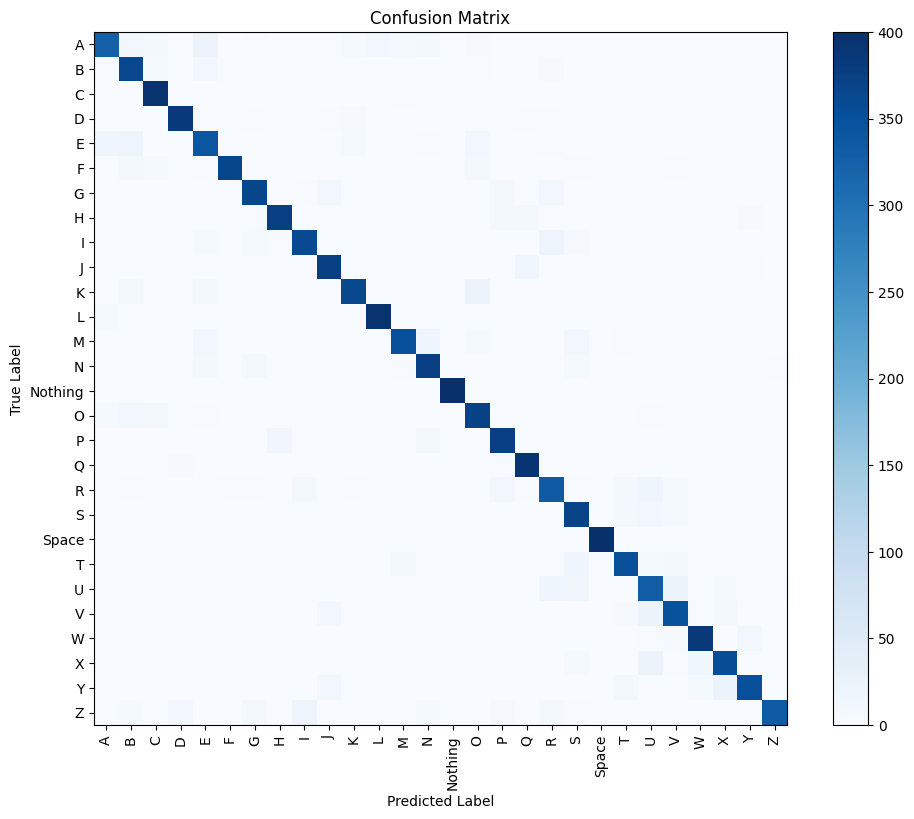

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=90)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()